
# Business Data Analytics Challenge: Prediction of Electricity Flows

  

Fabio Costa;  Laurin Eichberger;  Nevena Nikolajevic;  Ömer Özumerzifon;  Lukas Petry;  Hendrik Scherner  




---

## Kurze Einführung aus Notebook CNN_LSTM:

### Preprocessing 
Dieses Notebook im Rahmen der BDA Vorlesung hat zum Ziel, mithilfe eines Neuronalen Netzes Stromflüsse innerhalb Europa (von und nach Deutschland) vorherzusagen. 
Nach dem Einlesen der Daten werden diese zu erst bereinigt (Outlier) und skaliert. Anschließend werden Sie in ein passendes Format für das Modell geparst. Da in disesm NB ein CNN verwendet wird zur Feature Extraction, müssen die Daten pro Tag in einer `[24 x #Features]` Matrix vorliegen. Weiterhin können die 24h auch durch 48,72 etc. erweitert werden, falls pro Zeitschritt mehr als nur der letzte Tag betrachtet werden soll. 



### Modell
**1. CNN:**
Ein CNN wird zur Feature Extraction verwendet. Die Idee ist, dass die Filter-Kernel des CNNs eigenständige Features pro Zeitreihe lernt/findet, ohne dass diese Explizit angewendet werden müssen. 


**2. LSTM:**
Aufgrund der hohen auto-korrelation der einzelnen Zeitreihen, wird ein 2 stufiges LSTM verwendet, welches zeitabhängigkeiten gut abbilden kann. Das LSTM erzeugt pro Zeitschritt eine Output-Layer und erzeugt somit eine Matrix der Form `[#Zeitschritte x #Features]`. Anschließend wird mithilfe von einer Lambda Funktion der Output der letzten 24 Zeitschritte extrahiert und weitergereicht. 


**3. Dense:**
Mithilfe einer Dense Layer werden schlussendlich y_hat `[#24 x #Länder]` regressiert. 


**4. Experten Wissen:**
Innerhalb der vorangegangen Datenanalyse wurden folgende drei Punkte analysiert, welche anschließend auf y_hat angewendet wurden. 
    * Es liegen max. Kapazitäten für jede Grenze vor
    * Export>0
    * Import<0 
Dieses "Expertenwissen" wird als letzten Schritt auf y_hat angewandt. 

---

# Forecast Evaluation August

---

## Import Modules

In [1]:
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler
from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation
from keras.layers.core import Dense,Reshape,Dropout
from keras.layers import Input,LSTM,Lambda,Flatten
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler
import keras.backend as K

from scripts.model import data_preperation as preperation
from scripts.model import model as cnn_lstm
from scripts.model import evaluation as evaluation

from scripts.preprocessing_master import import_masterDataFrame
from scripts.preprocessing_master import preprocess_Rawdata

/Users/Schlendrikovic/Documents/Python/VirtualEnvironments/DeepLearning/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


---

# Import und Preprocessing

In [2]:
# Data Parameter
aggregate = False
rolling_days = 2
use_weightes_rmse = False

eval_from = "2019-08-01"
eval_to = "2019-08-31"

In [3]:
logging.info('Import model data')
df = preperation.import_model_data("data/Stromfluss/",'data/additional_input.csv',aggregate)

logging.info('Enrich with daily information')
df = preperation.extract_daily_informatin(df)


# Configurations
countries = ['NL', 'CHE', 'DNK', 'CZE', 'LUX', 'SWE', 'AUT','FRA', 'PL']
import_cols = [col+ "_IM" for col in countries]
export_cols = [col+ "_EX" for col in countries]

if not aggregate:
    countries = [col+ "_"+ nx_type for col in countries for nx_type in ['EX','IM']]

ind = ['Date','Tag','NX']
additional_input_columns = [col for col in df.columns  if (col not in countries) and (col not in ind) ]


logging.info('Gather maximum capacities')
export_max_capa = df[export_cols].max()
import_max_capa = df[import_cols].min()

logging.info('Remove Outlier')
df = preperation.remove_outlier(df, countries)

logging.info('Scale Data')
df,scaler = preperation.scale_data(df,countries,additional_input_columns)

logging.info('Aggregate Data for CNN')
df_nx = preperation.aggregate_nx(df, countries,rolling_days)
df_addx = preperation.aggregate_additional_input_data(df, additional_input_columns,rolling_days)

# Merge to master
df_master = pd.merge(df_nx,df_addx,on="Tag")
df_master['X_Attributes'] = df_master.apply(lambda row: np.concatenate((row.NX_per_country_shifted,row.Additional_X_aggregated),axis=1), axis=1 )
df_master.drop(['NX_per_country_shifted','Additional_X_aggregated'],axis=1,inplace=True)

Import File: Physikalischer_Stromfluss_201905010000_201905312359_1.csv 
Import File: DE_Physikalischer_Stromfluss_201506010000_201706012359_1.csv 
Import File: Physikalischer_Stromfluss_201706020000_201904302359_1.csv 


/Users/Schlendrikovic/Documents/Python/VirtualEnvironments/DeepLearning/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [4]:
logging.info('Evaluation Split')
df_eval = df_master.loc[(df_master.Tag>=eval_from) & (df_master.Tag<=eval_to)].reset_index(drop=True)

---

# Evaluation

## Import Model (CNN+LSTM)

In [5]:
logging.info("Evaluation")
model = load_model('best_model.h5')

## Plot

/Users/Schlendrikovic/Documents/Python/VirtualEnvironments/DeepLearning/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


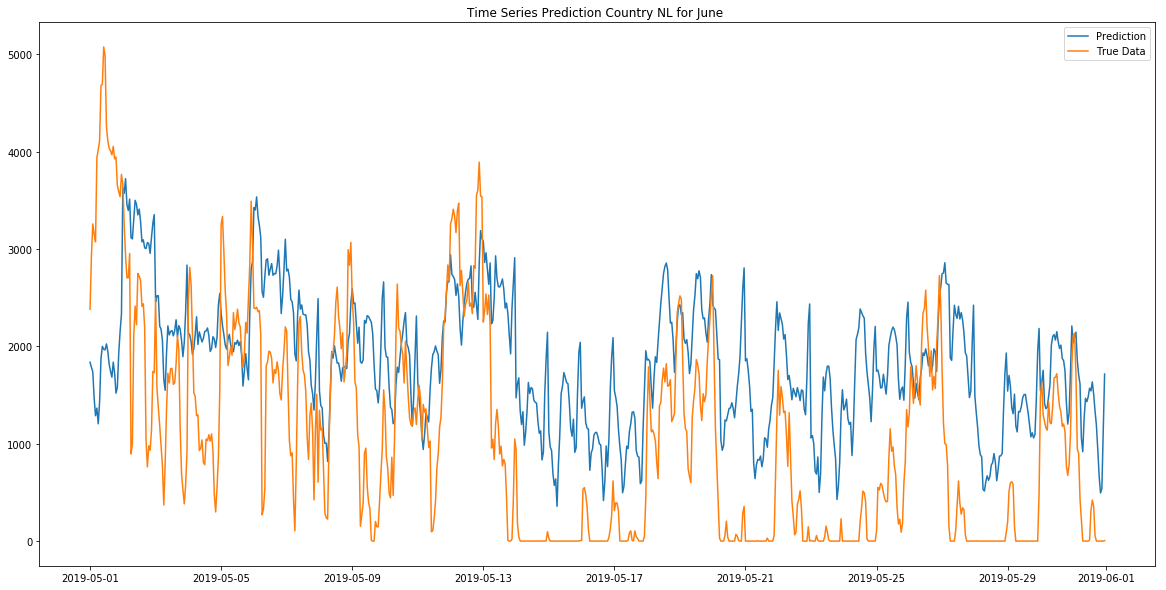

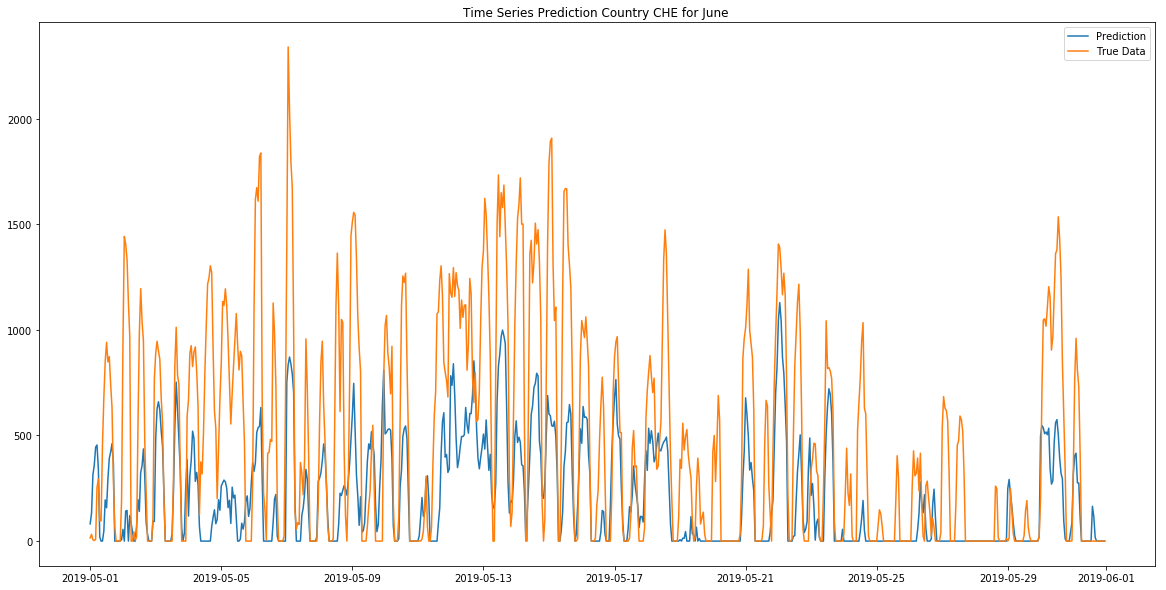

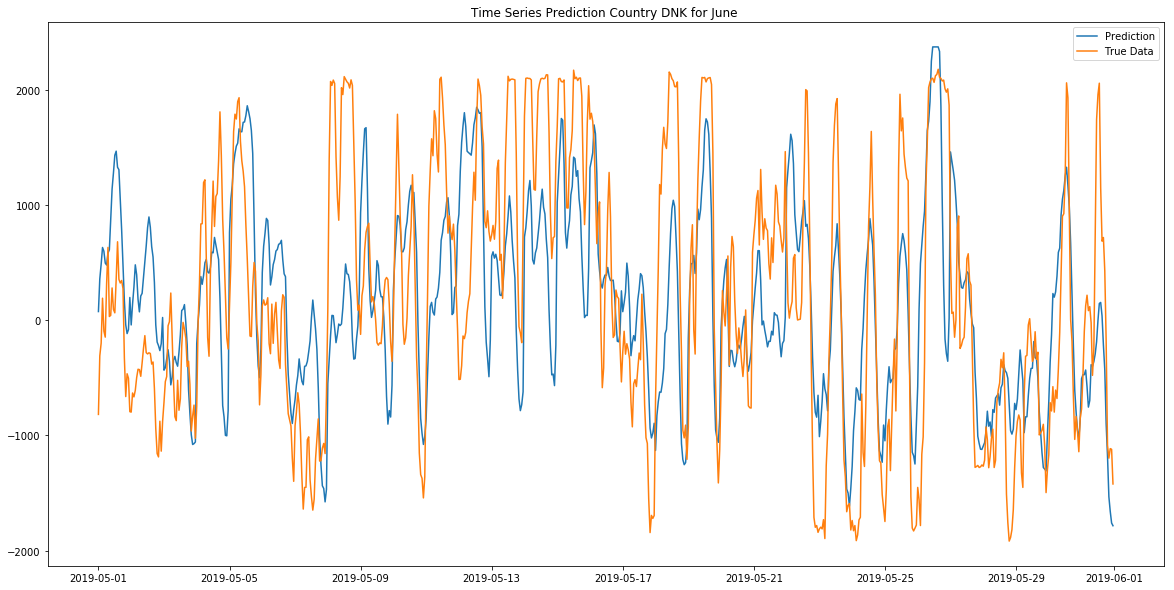

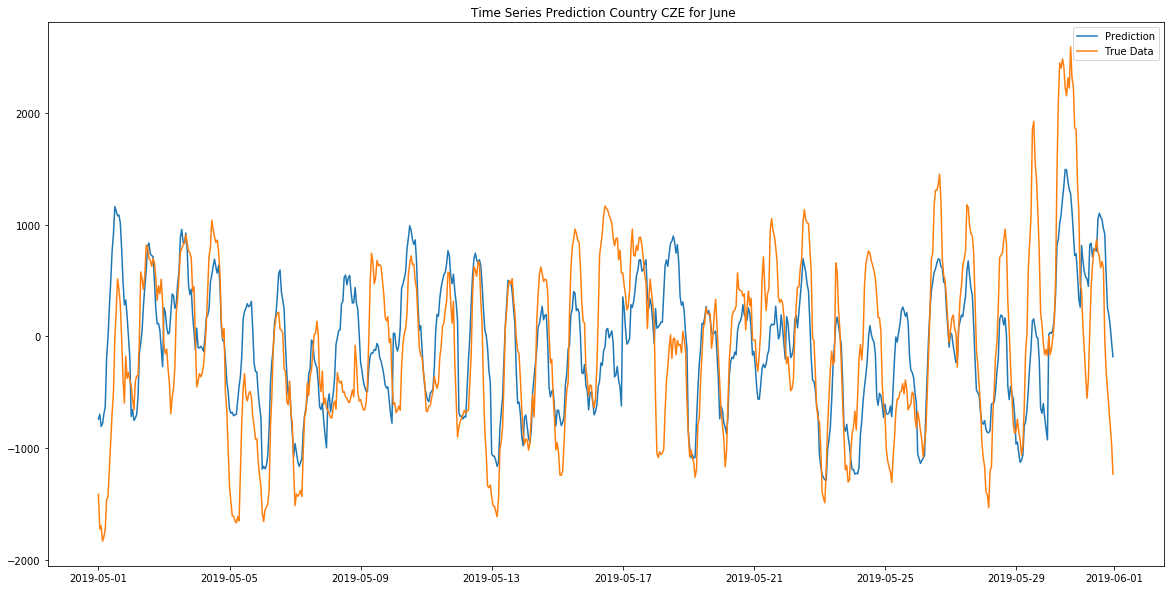

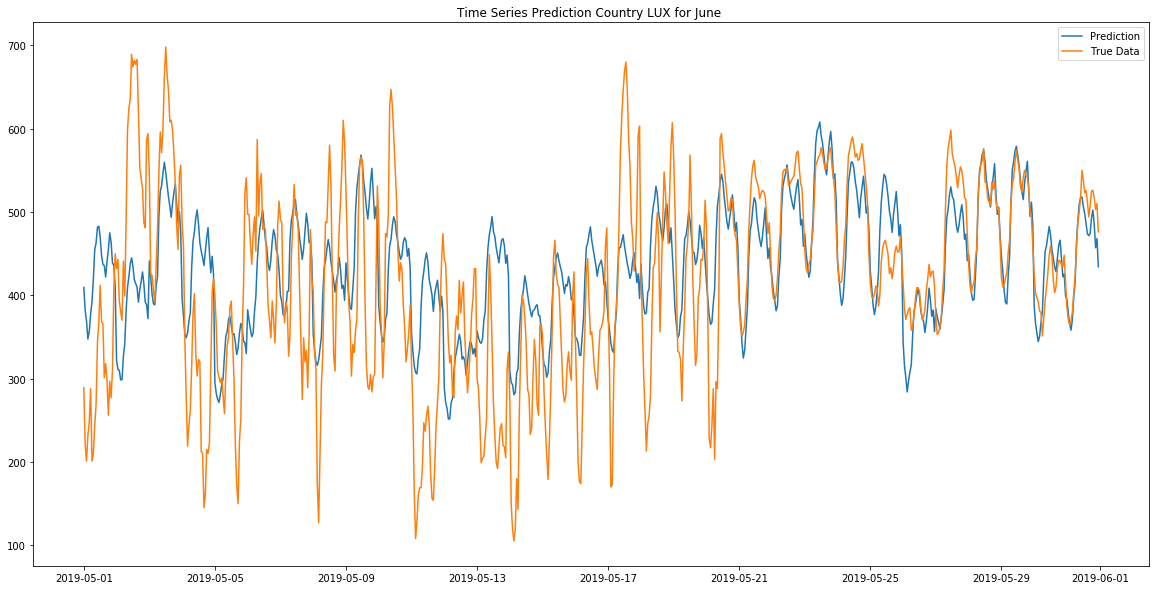

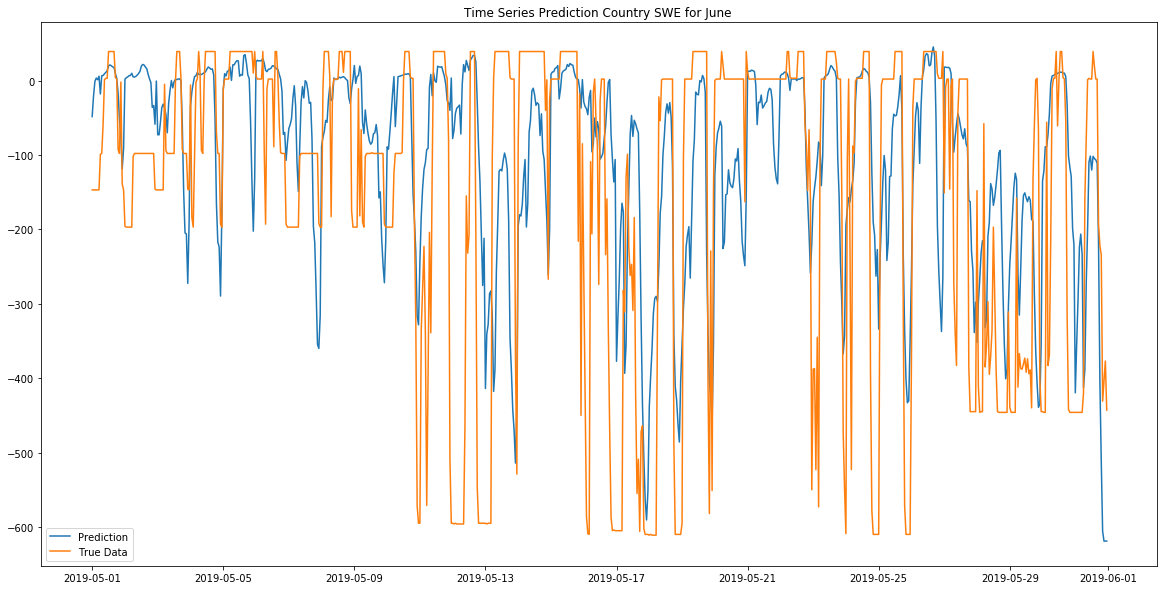

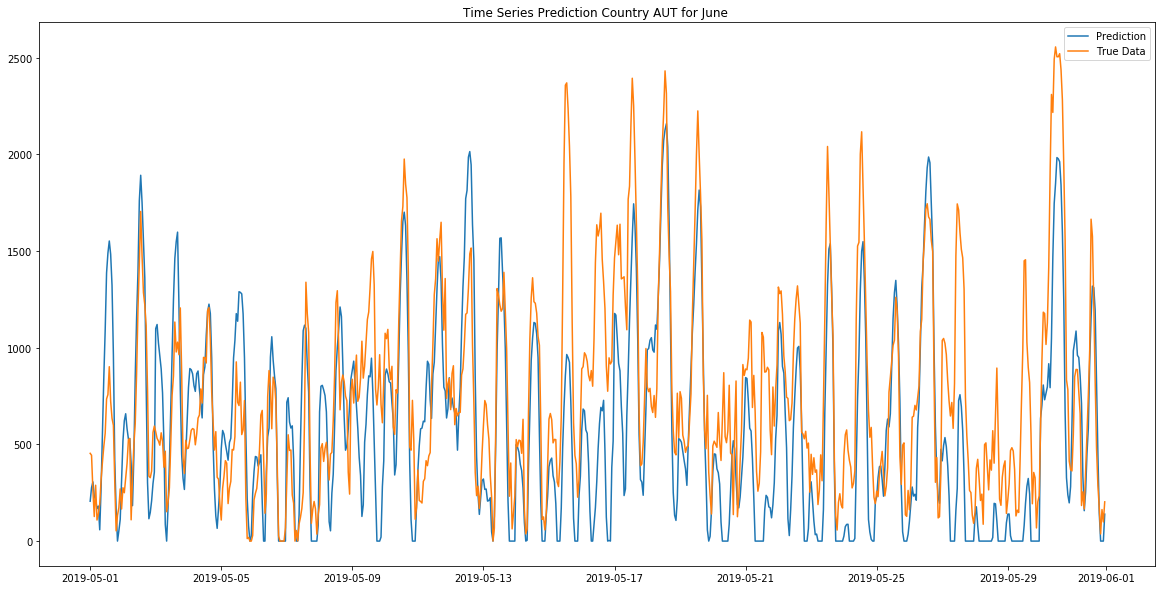

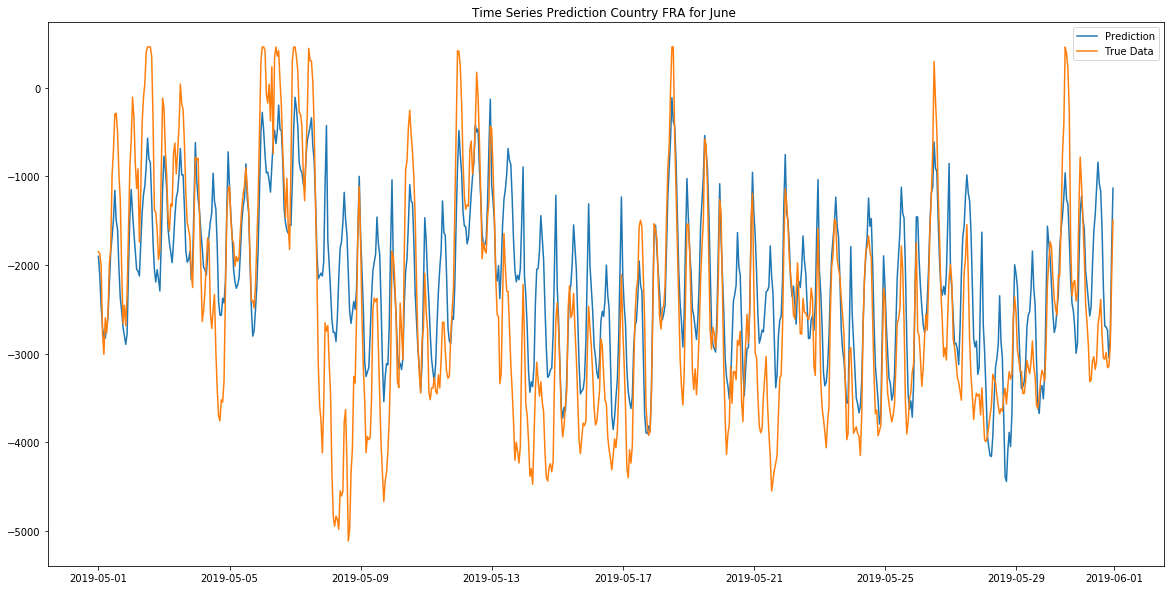

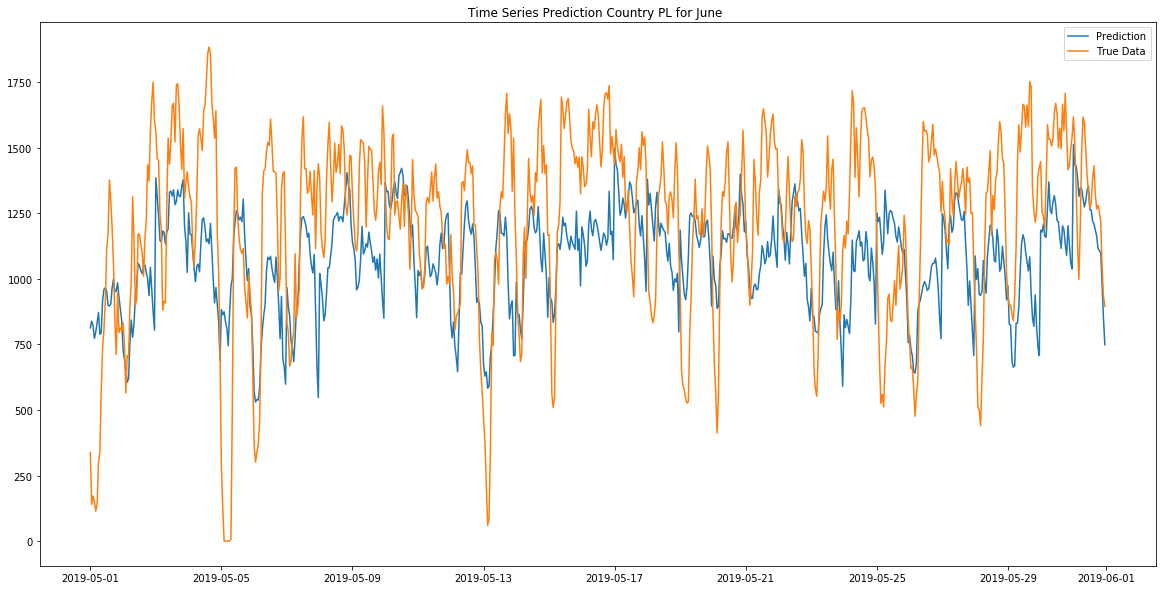

MAE:
NL     1027.789977
CHE     318.557011
DNK     696.310507
CZE     445.853484
LUX      71.951557
SWE     130.070250
AUT     327.784918
FRA     658.850586
PL      273.423684
dtype: float64

Gesamt:438.9546638712454


In [6]:
aggregate_prediction = True

df_predictions , df_true_eval_values = evaluation.predict(model,df_eval,countries)
df_predictions[countries] = scaler.inverse_transform(df_predictions[countries])
df_true_eval_values[countries] = scaler.inverse_transform(df_true_eval_values[countries])

df_predictions = evaluation.apply_expert_knowledge(df_predictions,import_cols,export_cols,import_max_capa,export_max_capa)

if aggregate_prediction:
    cols = ['NL', 'CHE', 'DNK', 'CZE', 'LUX', 'SWE', 'AUT','FRA', 'PL']
    df_predictions , df_true_eval_values = evaluation.aggregate_to_country(df_predictions, df_true_eval_values)
    evaluation.plot_and_calculate_error(df_predictions,df_true_eval_values,cols)      
else:
    evaluation.plot_and_calculate_error(df_predictions,df_true_eval_values,countries)
    

## Error

In [7]:
cols = ['NL', 'CHE', 'DNK', 'CZE', 'LUX', 'SWE', 'AUT','FRA', 'PL']
print("Weighted RMSE:\n")
evaluation.calculate_prediction_errors(df_predictions,df_true_eval_values,cols)

Weighted RMSE:

CNN LSTM Scaled RMSE: 671.9144177121385
--------------------------



# Write Predictions

In [ ]:
df_predictions.to_csv('Calculated_Predictions.csv',sep=";")

---